In [28]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from glob import glob
from io import StringIO
import pingouin as pg
import seaborn as sns
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['axes.unicode_minus'] = False # 한글 폰트 사용 시, 마이너스 글자가 깨지는 현상을 해결
import joblib

import processing

baseDir, childDir = os.path.split(os.getcwd())
data_dir = [i.replace('\\','/') for i in glob(os.path.join(baseDir, '**', '**', '*Table.xls'))]
label = pd.read_excel(os.path.join(baseDir, 'Mechanical Test DB - Impact.xlsx'))
label['chart_name'] = label['brand'] + " | " + label['model_name'] + " | " + label['test_date'].dt.strftime('%Y-%m-%d')

In [29]:
DATA = {}
for f in data_dir:
# 파일을 텍스트 형식으로 읽기
    with open(f, 'r', encoding='cp949') as file:
        lines = file.readlines()

        # 'Time' 행 이후의 데이터만 추출
        start_index = next(i for i, line in enumerate(lines) if 'Trial' in line)
        end_index = next(i for i, line in enumerate(lines) if 'Ave' in line)
        data_subset = lines[start_index:end_index]
        # 리스트를 문자열로 결합
        data_str = ''.join(data_subset)

        # StringIO를 사용해 데이터프레임으로 변환
        df = pd.read_csv(StringIO(data_str), delimiter='\t')
        df = df[~df['Trial'].str.contains('=+', na=False)].astype(float)
        df['force/pen (N/mm)'] = df['Force (N)'] / df['Max Pen (mm)']
        DATA[os.path.splitext(os.path.basename(f))[0]] = np.mean(df,axis=0)

In [30]:
chart_to_files = {}

# 폴더명에서 숫자 부분 추출 및 chart_name과 매칭
for folder in sorted(DATA.keys()):
    folder_num = folder.split('_')[0]
    
    # 매칭되는 chart_name을 찾기
    matching_row = label[label['shoe_num'].astype(str) == folder_num][['chart_name', 'category', 'shoe_mass']]
    
    if not matching_row.empty:
        chart_name = matching_row['chart_name'].values[0]
        
        # 해당 폴더 내의 모든 파일 경로를 리스트로 가져오기
        # 여기서는 폴더 경로를 사용해 모든 파일을 검색
        ff_file = []
        rf_file = []
        files_in_folder = [i for i in sorted(DATA.keys()) if folder_num in i][:2]
        if files_in_folder:
            for file in files_in_folder:
                if 'FF' in file:
                    ff_file = file
                elif 'RF' in file:
                    rf_file = file
            files_in_folder = [ff_file, rf_file]
        chart_to_files[chart_name] = files_in_folder, matching_row

In [31]:
DF = pd.DataFrame()
for chart in chart_to_files:
    try:
        FORE = pd.DataFrame(DATA[chart_to_files[chart][0][0]]).T.iloc[:,[4,8,9]]
        REAR = pd.DataFrame(DATA[chart_to_files[chart][0][1]]).T.iloc[:,[4,8,9]]
        # FORE = pd.DataFrame(DATA[chart_to_files[chart][0][0]]).T.iloc[:,1:]
        # REAR = pd.DataFrame(DATA[chart_to_files[chart][0][1]]).T.iloc[:,1:]
        LABEL = chart_to_files[chart][1].copy()
        LABEL = LABEL.reset_index(drop=True)
        FORE.columns = FORE.columns.str.replace(')', ') ForeFoot')
        REAR.columns = REAR.columns.str.replace(')', ') RearFoot')
        df = pd.concat([LABEL, FORE, REAR],axis=1)
    
    except Exception as e:
        # print(chart)
        pass

    DF = pd.concat([DF, df])

In [32]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import warnings
warnings.filterwarnings('ignore')

In [33]:
data = DF[DF['category'] == 'RUNNING'].reset_index(drop=True)

In [34]:
melted_df

,category,Measurement,Value
0,RUNNING,Force (N) ForeFoot,1396.866
1,RUNNING,Force (N) ForeFoot,1753.344
2,RUNNING,Force (N) ForeFoot,1705.754
3,RUNNING,Force (N) ForeFoot,1699.002
4,RUNNING,Force (N) ForeFoot,1867.460
...,...,...,...
1639,RUNNING,Max Pen (mm) RearFoot,17.596
1640,RUNNING,Max Pen (mm) RearFoot,16.798
1641,RUNNING,Max Pen (mm) RearFoot,19.150
1642,RUNNING,Max Pen (mm) RearFoot,19.150


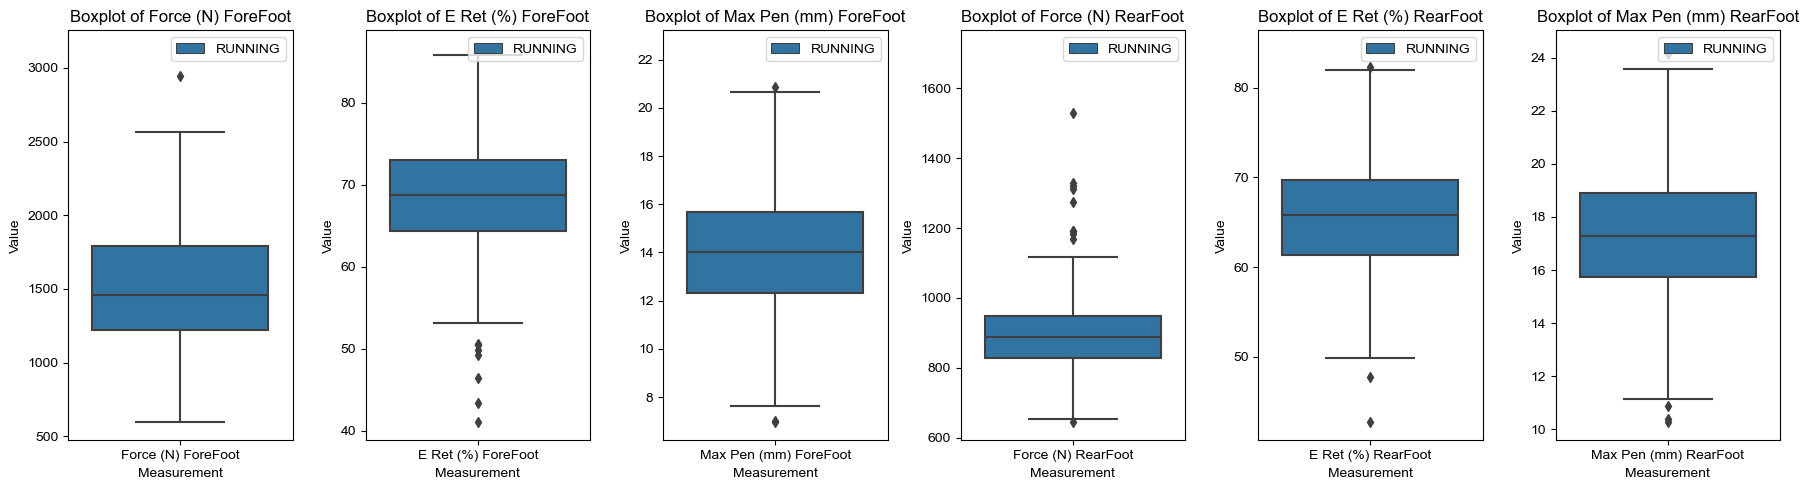

In [35]:
# 데이터 melt
melted_df = data.melt(
    id_vars=["category"],
    value_vars=[
        "Force (N) ForeFoot", "E Ret (%) ForeFoot", "Max Pen (mm) ForeFoot",
        "Force (N) RearFoot", "E Ret (%) RearFoot", "Max Pen (mm) RearFoot"
    ],
    var_name="Measurement",
    value_name="Value"
)

# 서브플롯을 사용하여 각 측정값을 개별적으로 시각화
measurements = melted_df['Measurement'].unique()

fig, axes = plt.subplots(1, len(measurements), figsize=(len(measurements) * 3, 5))
for i, measurement in enumerate(measurements):
    sns.boxplot(
        data=melted_df[melted_df['Measurement'] == measurement],
        x="Measurement",
        y="Value",
        hue="category",
        ax=axes[i]
    )
    axes[i].set_title(f"Boxplot of {measurement}")
    axes[i].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [36]:
num_cols = data.columns[3:]
df_num = data[num_cols]

In [38]:
sc = StandardScaler()
# sc = MinMaxScaler()
df_num_arr = sc.fit_transform(df_num)
df_num_sc = pd.DataFrame(df_num_arr, columns = num_cols)
pca = PCA(n_components=4)
pca_arr = pca.fit_transform(df_num_sc)
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

joblib.dump(sc, 'model/scaler_model.pkl')
joblib.dump(pca, 'model/pca_model.pkl')

[0.53444657 0.20734326 0.10959963 0.07835486]
0.9297443225888011


['model/pca_model.pkl']

In [39]:
pca_col = [f"pca_component_{i+1}" for i in range(pca.n_components_)]
df_pca = pd.DataFrame(pca_arr, columns=pca_col)
PCA_DF = pd.concat([data.iloc[:,:2],df_num_sc, df_pca], axis=1)

In [41]:
X = PCA_DF[num_cols]
Y1 = PCA_DF['pca_component_1']
Y2 = PCA_DF['pca_component_2']
Y3 = PCA_DF['pca_component_3']
Y4 = PCA_DF['pca_component_4']
# Y5 = PCA_DF['pca_component_5']
# Y6 = PCA_DF['pca_component_6']

In [42]:
# 하이퍼파라미터 그리드 설정
param_grid = {
    'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 5.0, 10.0],  # 규제 강도
    'l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],  # L1 규제 비율
}
model1 = ElasticNet()
clf1 = GridSearchCV(estimator = model1,
            param_grid=param_grid,
            scoring= 'accuracy')
clf1.fit(X,Y1)

model2 = ElasticNet()
clf2 = GridSearchCV(estimator = model2,
            param_grid=param_grid,
            scoring= 'accuracy')
clf2.fit(X,Y2)

model3 = ElasticNet()
clf3 = GridSearchCV(estimator = model3,
            param_grid=param_grid,
            scoring= 'accuracy')
clf3.fit(X,Y3)

model4 = ElasticNet()
clf4 = GridSearchCV(estimator = model4,
            param_grid=param_grid,
            scoring= 'accuracy')
clf4.fit(X,Y4)

# model5 = ElasticNet()
# clf5 = GridSearchCV(estimator = model5,
#             param_grid=param_grid,
#             scoring= 'accuracy')
# clf5.fit(X,Y5)

# model6 = ElasticNet()
# clf6 = GridSearchCV(estimator = model6,
#             param_grid=param_grid,
#             scoring= 'accuracy')
# clf6.fit(X,Y6)

GridSearchCV(estimator=ElasticNet(),
             param_grid={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                   1.0, 5.0, 10.0],
                         'l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                      0.9, 1.0]},
             scoring='accuracy')

In [43]:
clf1.best_estimator_, clf2.best_estimator_, clf3.best_estimator_, clf4.best_estimator_

(ElasticNet(alpha=0.1, l1_ratio=0),
 ElasticNet(alpha=0.1, l1_ratio=0),
 ElasticNet(alpha=0.1, l1_ratio=0),
 ElasticNet(alpha=0.1, l1_ratio=0))

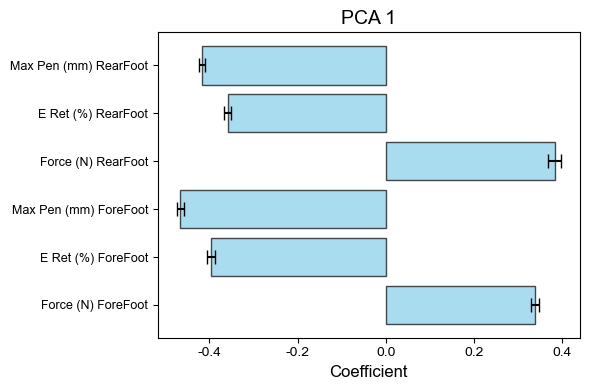

In [48]:
model1 = ElasticNet(alpha= clf1.best_estimator_.alpha, l1_ratio=clf1.best_estimator_.l1_ratio, random_state=0)
bootstrap_coefs = processing.bootstrap_coefficients(X, Y1,  model1, n_iterations = 1000)
bootstrap_coefs = bootstrap_coefs.reshape(-1, len(X.columns))
lower_bounds, upper_bounds = processing.compute_confidence_intervals(bootstrap_coefs)

mean_values = np.mean(bootstrap_coefs,axis=0)
# Error bar 계산 (절대값)
lower_errors = np.abs(mean_values - lower_bounds)
upper_errors = np.abs(upper_bounds - mean_values)
errors = [lower_errors, upper_errors]
# 바 그래프 그리기
plt.figure(figsize=(6, 4))
plt.barh(range(len(mean_values)), mean_values, xerr=errors, capsize=5, alpha=0.7, color='skyblue', edgecolor='black')
plt.yticks(range(len(num_cols)), num_cols, fontsize=9)
plt.xlabel('Coefficient', fontsize=12)
plt.title('PCA 1', fontsize=14)
plt.tight_layout()
# plt.savefig(f'{baseDir}/image/pca1.png',dpi=300)
plt.show()

# # model1.fit(X)
# y_pred = model1.predict(X)
# plt.plot(Y1)
# plt.plot(y_pred)

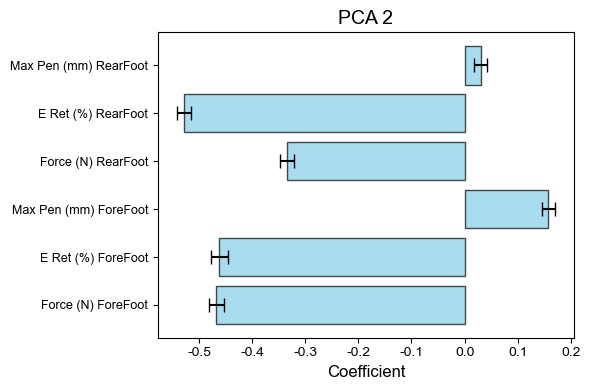

In [49]:
model2 = ElasticNet(alpha= clf2.best_estimator_.alpha, l1_ratio=clf2.best_estimator_.l1_ratio, random_state=0)
bootstrap_coefs = processing.bootstrap_coefficients(X, Y2,  model2, n_iterations = 1000)
bootstrap_coefs = bootstrap_coefs.reshape(-1, len(X.columns))
lower_bounds, upper_bounds = processing.compute_confidence_intervals(bootstrap_coefs)
mean_values = np.mean(bootstrap_coefs,axis=0)

# Error bar 계산 (절대값)
lower_errors = np.abs(mean_values - lower_bounds)
upper_errors = np.abs(upper_bounds - mean_values)
errors = [lower_errors, upper_errors]

# 바 그래프 그리기
plt.figure(figsize=(6, 4))
plt.barh(range(len(mean_values)), mean_values, xerr=errors, capsize=5, alpha=0.7, color='skyblue', edgecolor='black')
plt.yticks(range(len(num_cols)), num_cols, fontsize=9)
plt.xlabel('Coefficient', fontsize=12)
plt.title('PCA 2', fontsize=14)
plt.tight_layout()
plt.savefig(f'{baseDir}/image/pca2.png',dpi=300)
plt.show()

# # model2.fit(X)
# y_pred_2 = model2.predict(X)
# plt.plot(Y2)
# plt.plot(y_pred_2)

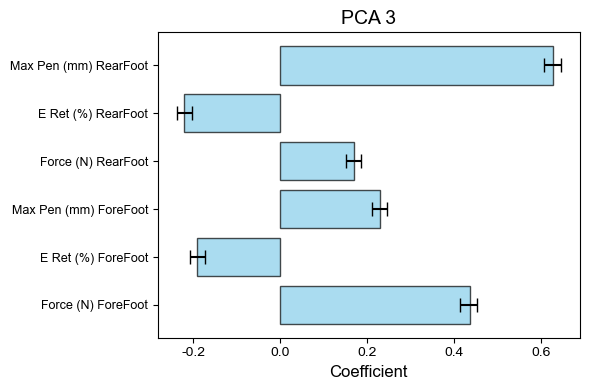

In [50]:
model3 = ElasticNet(alpha= clf3.best_estimator_.alpha, l1_ratio=clf3.best_estimator_.l1_ratio, random_state=0)
bootstrap_coefs = processing.bootstrap_coefficients(X, Y3,  model3, n_iterations = 1000)
bootstrap_coefs = bootstrap_coefs.reshape(-1, len(X.columns))
lower_bounds, upper_bounds = processing.compute_confidence_intervals(bootstrap_coefs)
mean_values = np.mean(bootstrap_coefs,axis=0)

# Error bar 계산 (절대값)
lower_errors = np.abs(mean_values - lower_bounds)
upper_errors = np.abs(upper_bounds - mean_values)
errors = [lower_errors, upper_errors]

# 바 그래프 그리기
plt.figure(figsize=(6, 4))
plt.barh(range(len(mean_values)), mean_values, xerr=errors, capsize=5, alpha=0.7, color='skyblue', edgecolor='black')
plt.yticks(range(len(num_cols)), num_cols, fontsize=9)
plt.xlabel('Coefficient', fontsize=12)
plt.title('PCA 3', fontsize=14)
plt.tight_layout()
plt.savefig(f'{baseDir}/image/pca3.png',dpi=300)
plt.show()

# y_pred_3 = model3.predict(X)
# plt.plot(Y3)
# plt.plot(y_pred_3)

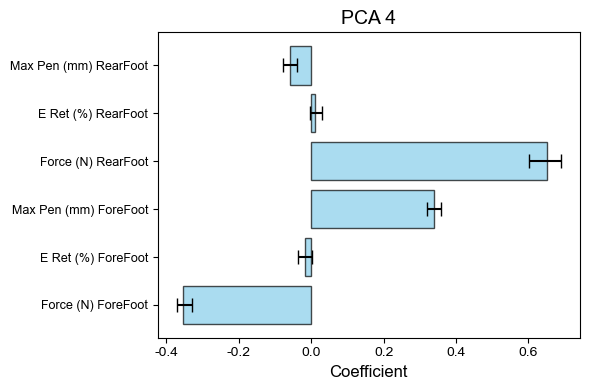

In [51]:
model4 = ElasticNet(alpha= clf4.best_estimator_.alpha, l1_ratio=clf4.best_estimator_.l1_ratio, random_state=0)
bootstrap_coefs = processing.bootstrap_coefficients(X, Y4,  model4, n_iterations = 1000)
bootstrap_coefs = bootstrap_coefs.reshape(-1, len(X.columns))
lower_bounds, upper_bounds = processing.compute_confidence_intervals(bootstrap_coefs)
mean_values = np.mean(bootstrap_coefs,axis=0)

# Error bar 계산 (절대값)
lower_errors = np.abs(mean_values - lower_bounds)
upper_errors = np.abs(upper_bounds - mean_values)
errors = [lower_errors, upper_errors]

# 바 그래프 그리기
plt.figure(figsize=(6, 4))
plt.barh(range(len(mean_values)), mean_values, xerr=errors, capsize=5, alpha=0.7, color='skyblue', edgecolor='black')
plt.yticks(range(len(num_cols)), num_cols, fontsize=9)
plt.xlabel('Coefficient', fontsize=12)
plt.title('PCA 4', fontsize=14)
plt.tight_layout()
plt.savefig(f'{baseDir}/image/pca4.png',dpi=300)
plt.show()

# # model4.fit(X,Y4)
# y_pred_4 = model4.predict(X)
# plt.plot(Y4)
# plt.plot(y_pred_4)

In [18]:
# model5 = ElasticNet(alpha= clf5.best_estimator_.alpha, l1_ratio=clf5.best_estimator_.l1_ratio, random_state=0)
# bootstrap_coefs = processing.bootstrap_coefficients(X, Y5,  model5, n_iterations = 1000)
# bootstrap_coefs = bootstrap_coefs.reshape(-1, len(X.columns))
# lower_bounds, upper_bounds = processing.compute_confidence_intervals(bootstrap_coefs)
# mean_values = np.mean(bootstrap_coefs,axis=0)

# # Error bar 계산 (절대값)
# lower_errors = np.abs(mean_values - lower_bounds)
# upper_errors = np.abs(upper_bounds - mean_values)
# errors = [lower_errors, upper_errors]

# # 바 그래프 그리기
# plt.figure(figsize=(6, 4))
# plt.barh(range(len(mean_values)), mean_values, xerr=errors, capsize=5, alpha=0.7, color='skyblue', edgecolor='black')
# plt.yticks(range(len(num_cols)), num_cols, fontsize=9)
# plt.xlabel('Coefficient', fontsize=12)
# plt.title('PCA 5', fontsize=14)
# plt.tight_layout()
# plt.savefig(f'{baseDir}/image/pca5.png',dpi=300)
# plt.show()

# # model5.fit(X,Y5)
# y_pred_5 = model5.predict(X)
# plt.plot(Y5)
# plt.plot(y_pred_5)

In [19]:
# model6 = ElasticNet(alpha= clf6.best_estimator_.alpha, l1_ratio=clf6.best_estimator_.l1_ratio, random_state=0)
# bootstrap_coefs = processing.bootstrap_coefficients(X, Y6,  model6, n_iterations = 1000)
# bootstrap_coefs = bootstrap_coefs.reshape(-1, len(X.columns))
# lower_bounds, upper_bounds = processing.compute_confidence_intervals(bootstrap_coefs)
# mean_values = np.mean(bootstrap_coefs,axis=0)

# # Error bar 계산 (절대값)
# lower_errors = np.abs(mean_values - lower_bounds)
# upper_errors = np.abs(upper_bounds - mean_values)
# errors = [lower_errors, upper_errors]

# # 바 그래프 그리기
# plt.figure(figsize=(6, 4))
# plt.barh(range(len(mean_values)), mean_values, xerr=errors, capsize=5, alpha=0.7, color='skyblue', edgecolor='black')
# plt.yticks(range(len(num_cols)), num_cols, fontsize=9)
# plt.xlabel('Coefficient', fontsize=12)
# plt.title('PCA 6', fontsize=14)
# plt.tight_layout()
# plt.savefig(f'{baseDir}/image/pca6.png',dpi=300)
# plt.show()

# # model6.fit(X,Y6)
# y_pred_6 = model6.predict(X)
# plt.plot(Y6)
# plt.plot(y_pred_6)

In [53]:
X_features = PCA_DF[['pca_component_1','pca_component_2','pca_component_3','pca_component_4', 
                    #  'pca_component_5','pca_component_6'
                     ]]

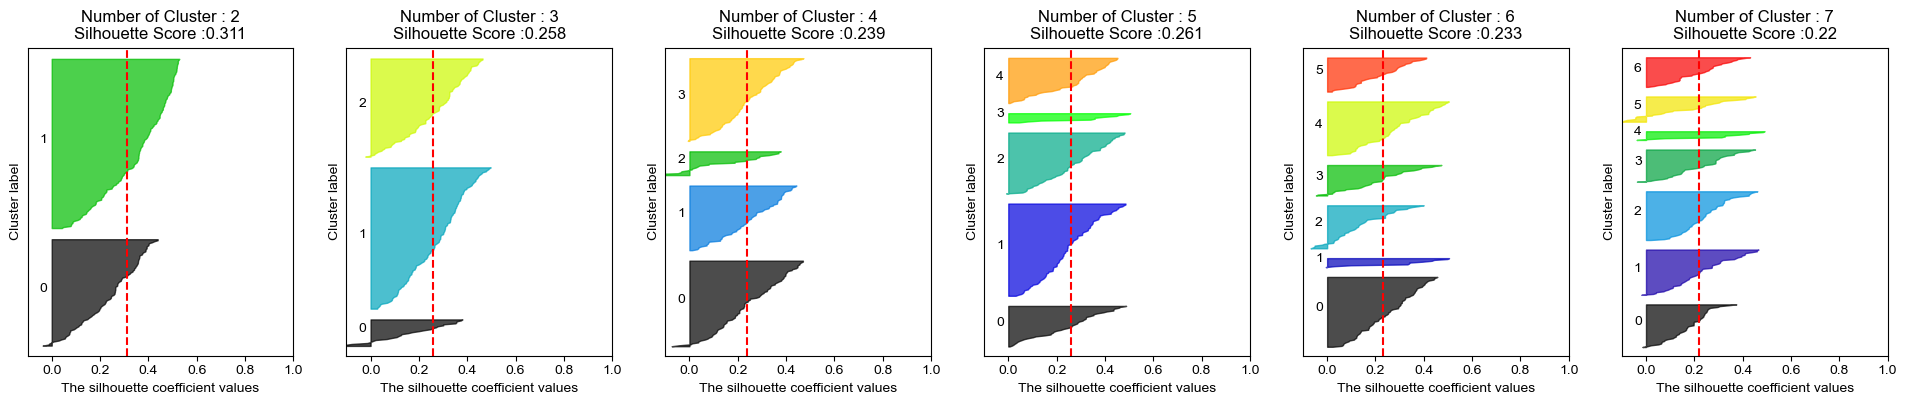

In [54]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features): 
    
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, random_state=0, init='k-means++', n_init= 10, max_iter=500)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")
    
    
    return fig
fig = visualize_silhouette([2, 3, 4, 5, 6, 7],  X_features)
fig.savefig(f'{baseDir}/image/kmean.png',dpi=300)
fig.show()

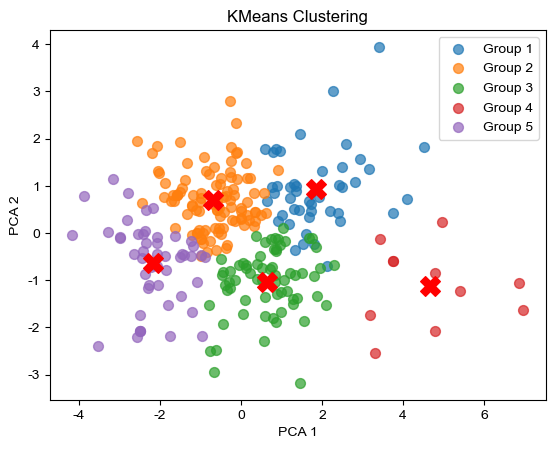

In [55]:
X =PCA_DF[['pca_component_1','pca_component_2','pca_component_3','pca_component_4', 
        #    'pca_component_5','pca_component_6'
           ]]
kmeans = KMeans(n_clusters = 5, random_state=0, init='k-means++', n_init= 10, max_iter=500)
kmeans.fit(X)
labels = kmeans.labels_ + 1
centroids = kmeans.cluster_centers_  # 클러스터 중심점# 결과 시각화
# joblib.dump(kmeans, 'model/kmeans_model.pkl')

# 각 클러스터의 데이터를 개별적으로 시각화
for i in range(1, 6):  # 클러스터가 1부터 시작하므로
    cluster_data = X[labels == i]
    plt.scatter(cluster_data.iloc[:, 0], cluster_data.iloc[:, 1], label=f'Group {i}', alpha=0.7, s=50)

# 클러스터 중심점(Centroids) 시각화
plt.scatter(
    centroids[:, 0], centroids[:, 1],
    c='red', s=200, marker='X'
)
plt.title("KMeans Clustering")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.savefig(f'{baseDir}/image/clustring.png',dpi=300)
plt.show()

In [56]:
data['cluster'] = labels

group1 = data[data['cluster'] == 1]
group2 = data[data['cluster'] == 2]
group3 = data[data['cluster'] == 3]
group4 = data[data['cluster'] == 4]
group5 = data[data['cluster'] == 5]

In [57]:
len(group1), len(group2), len(group3), len(group4), len(group5), len(group1)+len(group2)+len(group3)+len(group4)+len(group5)

(45, 101, 67, 11, 50, 274)

In [58]:
usecols = ['Force (N) ForeFoot', 'E Ret (%) ForeFoot',
       'Max Pen (mm) ForeFoot', 'Force (N) RearFoot', 'E Ret (%) RearFoot',
       'Max Pen (mm) RearFoot']

for c in usecols:
    print(c)
    result = pg.anova(data = data, dv=c,between='cluster').round(3)
    tukey = pg.pairwise_tukey(data=data, dv=c,between='cluster', effsize='cohen').round(3)
    display(result), display(tukey)

Force (N) ForeFoot


,Source,ddof1,ddof2,F,p-unc,np2
0,cluster,4,269,93.577,0.0,0.582


,A,B,mean(A),mean(B),diff,se,T,p-tukey,cohen
0,1,2,1517.333,1315.015,202.318,48.172,4.200,0.000,0.808
1,1,3,1517.333,1921.778,-404.445,51.803,-7.807,0.000,-1.392
2,1,4,1517.333,2413.985,-896.652,90.402,-9.919,0.000,-3.135
3,1,5,1517.333,1265.964,251.370,55.228,4.552,0.000,0.843
4,2,3,1315.015,1921.778,-606.763,42.349,-14.328,0.000,-2.402
5,2,4,1315.015,2413.985,-1098.970,85.337,-12.878,0.000,-4.816
6,2,5,1315.015,1265.964,49.052,46.476,1.055,0.829,0.193
7,3,4,1921.778,2413.985,-492.207,87.438,-5.629,0.000,-1.753
8,3,5,1921.778,1265.964,655.814,50.229,13.056,0.000,2.241
9,4,5,2413.985,1265.964,1148.021,89.510,12.826,0.000,3.950


E Ret (%) ForeFoot


,Source,ddof1,ddof2,F,p-unc,np2
0,cluster,4,269,98.577,0.0,0.594


,A,B,mean(A),mean(B),diff,se,T,p-tukey,cohen
0,1,2,59.902,67.952,-8.050,0.837,-9.618,0.000,-1.800
1,1,3,59.902,70.113,-10.211,0.900,-11.345,0.000,-1.898
2,1,4,59.902,56.662,3.240,1.571,2.063,0.239,0.502
3,1,5,59.902,76.906,-17.003,0.960,-17.720,0.000,-3.309
4,2,3,67.952,70.113,-2.161,0.736,-2.937,0.029,-0.526
5,2,4,67.952,56.662,11.290,1.483,7.615,0.000,2.746
6,2,5,67.952,76.906,-8.953,0.807,-11.088,0.000,-2.403
7,3,4,70.113,56.662,13.451,1.519,8.854,0.000,2.520
8,3,5,70.113,76.906,-6.792,0.873,-7.783,0.000,-1.495
9,4,5,56.662,76.906,-20.244,1.555,-13.017,0.000,-4.103


Max Pen (mm) ForeFoot


,Source,ddof1,ddof2,F,p-unc,np2
0,cluster,4,269,103.221,0.0,0.606


,A,B,mean(A),mean(B),diff,se,T,p-tukey,cohen
0,1,2,11.735,15.339,-3.603,0.296,-12.185,0.000,-2.168
1,1,3,11.735,12.580,-0.844,0.318,-2.655,0.064,-0.563
2,1,4,11.735,9.395,2.340,0.555,4.217,0.000,1.454
3,1,5,11.735,16.628,-4.892,0.339,-14.429,0.000,-2.636
4,2,3,15.339,12.580,2.759,0.260,10.612,0.000,1.786
5,2,4,15.339,9.395,5.944,0.524,11.345,0.000,3.667
6,2,5,15.339,16.628,-1.289,0.285,-4.517,0.000,-0.726
7,3,4,12.580,9.395,3.185,0.537,5.933,0.000,2.358
8,3,5,12.580,16.628,-4.048,0.308,-13.127,0.000,-2.430
9,4,5,9.395,16.628,-7.233,0.550,-13.162,0.000,-3.818


Force (N) RearFoot


,Source,ddof1,ddof2,F,p-unc,np2
0,cluster,4,269,90.163,0.0,0.573


,A,B,mean(A),mean(B),diff,se,T,p-tukey,cohen
0,1,2,928.754,852.868,75.885,14.499,5.234,0.000,0.990
1,1,3,928.754,956.207,-27.454,15.592,-1.761,0.399,-0.375
2,1,4,928.754,1295.777,-367.023,27.210,-13.488,0.000,-3.356
3,1,5,928.754,840.911,87.843,16.623,5.284,0.000,1.114
4,2,3,852.868,956.207,-103.339,12.747,-8.107,0.000,-1.456
5,2,4,852.868,1295.777,-442.908,25.686,-17.243,0.000,-4.921
6,2,5,852.868,840.911,11.957,13.989,0.855,0.913,0.161
7,3,4,956.207,1295.777,-339.569,26.318,-12.903,0.000,-3.711
8,3,5,956.207,840.911,115.296,15.119,7.626,0.000,1.639
9,4,5,1295.777,840.911,454.866,26.942,16.883,0.000,4.423


E Ret (%) RearFoot


,Source,ddof1,ddof2,F,p-unc,np2
0,cluster,4,269,101.048,0.0,0.6


,A,B,mean(A),mean(B),diff,se,T,p-tukey,cohen
0,1,2,58.822,64.131,-5.309,0.787,-6.744,0.00,-1.221
1,1,3,58.822,68.027,-9.205,0.847,-10.873,0.00,-1.856
2,1,4,58.822,57.745,1.077,1.477,0.729,0.95,0.205
3,1,5,58.822,75.058,-16.236,0.903,-17.989,0.00,-3.373
4,2,3,64.131,68.027,-3.896,0.692,-5.629,0.00,-0.942
5,2,4,64.131,57.745,6.386,1.395,4.579,0.00,1.663
6,2,5,64.131,75.058,-10.926,0.759,-14.387,0.00,-2.789
7,3,4,68.027,57.745,10.282,1.429,7.196,0.00,2.236
8,3,5,68.027,75.058,-7.031,0.821,-8.565,0.00,-1.582
9,4,5,57.745,75.058,-17.312,1.463,-11.836,0.00,-4.095


Max Pen (mm) RearFoot


,Source,ddof1,ddof2,F,p-unc,np2
0,cluster,4,269,67.941,0.0,0.503


,A,B,mean(A),mean(B),diff,se,T,p-tukey,cohen
0,1,2,14.454,18.482,-4.028,0.314,-12.845,0.000,-2.285
1,1,3,14.454,16.736,-2.281,0.337,-6.766,0.000,-1.416
2,1,4,14.454,13.402,1.052,0.588,1.788,0.383,0.621
3,1,5,14.454,18.961,-4.506,0.359,-12.536,0.000,-2.595
4,2,3,18.482,16.736,1.746,0.276,6.335,0.000,1.003
5,2,4,18.482,13.402,5.080,0.555,9.145,0.000,2.761
6,2,5,18.482,18.961,-0.479,0.303,-1.583,0.510,-0.262
7,3,4,16.736,13.402,3.334,0.569,5.858,0.000,2.003
8,3,5,16.736,18.961,-2.225,0.327,-6.805,0.000,-1.302
9,4,5,13.402,18.961,-5.559,0.583,-9.541,0.000,-2.979


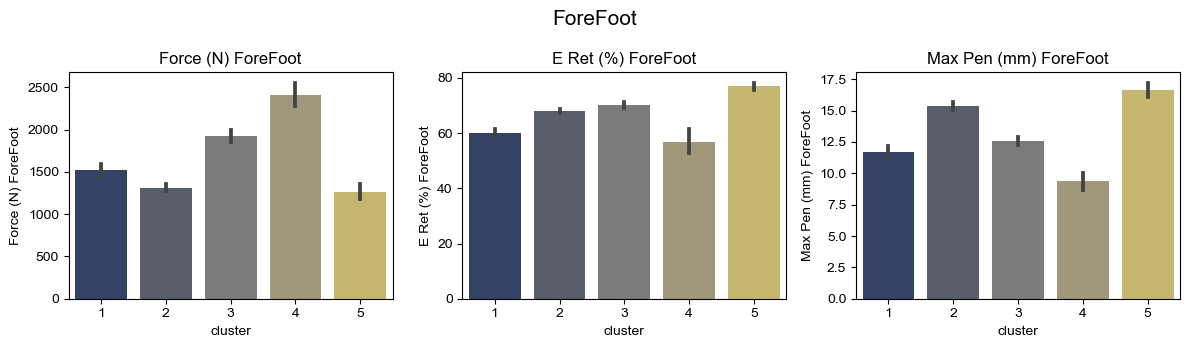

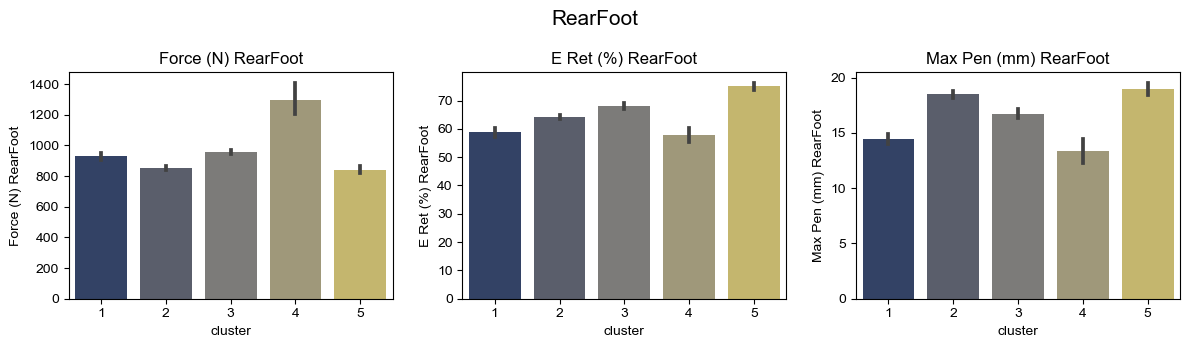

In [59]:
fig, ax = plt.subplots(1,3, figsize=(12,3.5))
sns.barplot(data=data, x='cluster', y=usecols[0],ax=ax[0],palette='cividis')
sns.barplot(data=data, x='cluster', y=usecols[1],ax=ax[1],palette='cividis')
sns.barplot(data=data, x='cluster', y=usecols[2],ax=ax[2],palette='cividis')
ax[0].set_title(usecols[0])
ax[1].set_title(usecols[1])
ax[2].set_title(usecols[2])
plt.suptitle('ForeFoot', fontsize=15)
plt.tight_layout()
plt.savefig(f"{baseDir}/image/forefoot.png", dpi=300)
plt.show()

fig, ax = plt.subplots(1,3, figsize=(12,3.5))
sns.barplot(data=data, x='cluster', y=usecols[3],ax=ax[0],palette='cividis')
sns.barplot(data=data, x='cluster', y=usecols[4],ax=ax[1],palette='cividis')
sns.barplot(data=data, x='cluster', y=usecols[5],ax=ax[2],palette='cividis')
ax[0].set_title(usecols[3])
ax[1].set_title(usecols[4])
ax[2].set_title(usecols[5])
plt.suptitle('RearFoot', fontsize=15)
plt.tight_layout()
plt.savefig(f"{baseDir}/image/rearfoot.png", dpi=300)
plt.show()